In [1]:
pip install tensorflow scikit-image

In [ ]:
import os
import numpy as np
from skimage.color import rgb2lab,lab2rgb
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers,losses


In [ ]:
IMG_SIZE=32
BATCH_SIZE=128
AUTOTUNE=tf.data.AUTOTUNE

def load_cifar10_lab():
    (x_train,_),(x_test,_)=tf.keras.datasets.cifar10.load_data()
    x=np.concatenate([x_train,x_test],axis=0).astype("float32")/255.0
    labs=[]
    for img in x:
        labs.append(rgb2lab(img))
    labs=np.array(labs,dtype="float32")
    L=labs[...,0:1]
    ab=labs[...,1:3]
    L_norm=L/100.0
    ab_norm=ab/128.0

    return L_norm,ab_norm,L,ab


In [ ]:
def make_dataset(L_norm,ab_norm,batch_size=BATCH_SIZE,shuffle=True):
    ds=tf.data.Dataset.from_tensor_slices((L_norm,ab_norm))
    if shuffle:
        ds=ds.shuffle(buffer_size=len(L_norm),reshuffle_each_iteration=True)
    ds=ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [ ]:
def build_cnn_colorizer(final_activation="tanh"):
    inputs=layers.Input(shape=(IMG_SIZE,IMG_SIZE,1))

    x=layers.Conv2D(64,(3,3),strides=(2,2),padding="same",activation="relu")(inputs)
    x=layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x=layers.Conv2D(256,(3,3),padding="same",activation="relu")(x)
    x=layers.Conv2D(512,(3,3),strides=(2,2),padding="same",activation="relu")(x)
    x=layers.Conv2D(256,(3,3),padding="same",activation="relu")(x)
    x=layers.Conv2D(128,(3,3),strides=(2,2),padding="same",activation="relu")(x)
    x=layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x=layers.UpSampling2D((2,2))(x)
    x=layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x=layers.UpSampling2D((2,2))(x)
    x=layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x=layers.UpSampling2D((2,2))(x)
    x=layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
    outputs=layers.Conv2D(2,(3,3),padding="same",activation=final_activation)(x)
    model=models.Model(inputs,outputs,name=f"cnn_colorizer_{final_activation}")
    return model


In [ ]:
def train_cnn_colorizer(train_ds,epochs=50,lr=1e-2):
    model=build_cnn_colorizer(final_activation="tanh")

    def lr_schedule(epoch,lr_current):
        if epoch>0 and epoch%15==0:
            return lr_current*0.5
        return lr_current

    optimizer=optimizers.SGD(learning_rate=lr,momentum=0.9)
    model.compile(optimizer=optimizer,loss="mse",metrics=["mae"])
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)]
    model.fit(train_ds,epochs=epochs,callbacks=callbacks)
    return model



In [ ]:
L_norm,ab_norm,L_orig,ab_orig=load_cifar10_lab()
train_ds=make_dataset(L_norm,ab_norm)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [ ]:
cnn_model=train_cnn_colorizer(train_ds,epochs=50,lr=1e-2)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - loss: 0.0110 - mae: 0.0712 - learning_rate: 0.0100
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 0.0109 - mae: 0.0710 - learning_rate: 0.0100
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0109 - mae: 0.0709 - learning_rate: 0.0100
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0108 - mae: 0.0707 - learning_rate: 0.0100
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0108 - mae: 0.0705 - learning_rate: 0.0100
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0107 - mae: 0.0703 - learning_rate: 0.0100
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - loss: 0.0106 - mae: 0.0698 - learning_rate: 0.0100
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - loss: 0.0106 - mae: 0.0699 - learning_rate: 0.0100
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - loss: 0.0106 - mae: 0.0696 - learning_rate: 0.0100
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━

In [ ]:
idx=0
test_L=L_norm[idx:idx+1]


In [ ]:
pred_ab=cnn_model.predict(test_L)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [ ]:
def reconstruct_rgb(L_norm_single,ab_norm_single):
    L=L_norm_single*100.0
    ab=ab_norm_single*128.0
    lab=np.concatenate([L,ab],axis=-1)
    rgb=lab2rgb(lab.astype("float64"))
    return np.clip(rgb,0,1)

rgb_img=reconstruct_rgb(test_L[0],pred_ab[0])


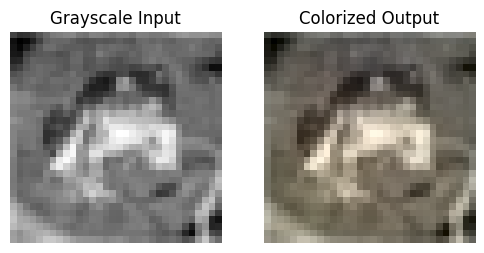

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Grayscale Input")
plt.imshow(test_L[0].reshape(32,32),cmap="gray")
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Colorized Output")
plt.imshow(rgb_img)
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


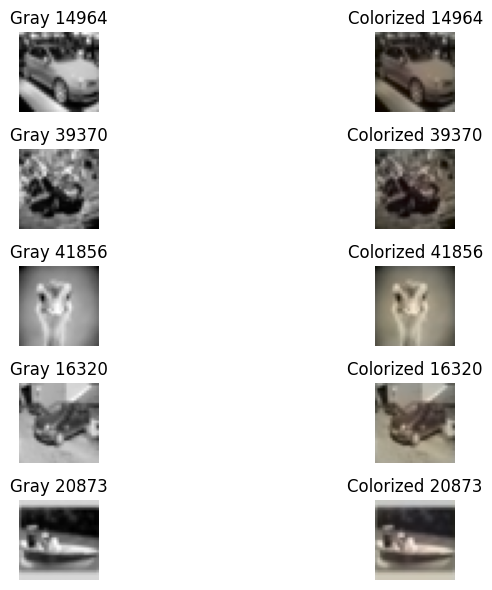

In [ ]:
import matplotlib.pyplot as plt
import random
indices=random.sample(range(len(L_norm)),5)

plt.figure(figsize=(10,6))

for i,idx in enumerate(indices):
    test_L=L_norm[idx:idx+1]
    pred_ab=cnn_model.predict(test_L)
    rgb_img=reconstruct_rgb(test_L[0],pred_ab[0])
    plt.subplot(5,2,2*i+1)
    plt.title(f"Gray {idx}")
    plt.imshow(test_L[0].reshape(32,32),cmap="gray")
    plt.axis("off")

    plt.subplot(5,2,2*i+2)
    plt.title(f"Colorized {idx}")
    plt.imshow(rgb_img)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [23]:
from skimage.metrics import structural_similarity as ssim

In [ ]:
def evaluate_model(model,L_norm,ab_norm,num_samples=500):
    num_samples=min(num_samples,len(L_norm))
    idxs=np.random.choice(len(L_norm),num_samples,replace=False)

    mse_list=[]
    mae_list=[]
    psnr_list=[]
    ssim_list=[]

    for idx in idxs:
        test_L=L_norm[idx:idx+1]
        ab_true=ab_norm[idx]
        ab_pred=model.predict(test_L)[0]
        mse=np.mean((ab_true-ab_pred)**2)
        mae=np.mean(np.abs(ab_true-ab_pred))

        def lab_to_rgb(Ln,abn):
            L=Ln*100.0
            ab=abn*128.0
            lab=np.concatenate([L,ab],axis=-1)
            rgb=lab2rgb(lab.astype("float64"))
            return np.clip(rgb,0,1)
        rgb_true=lab_to_rgb(L_norm[idx],ab_true)
        rgb_pred=lab_to_rgb(L_norm[idx],ab_pred)

        psnr=tf.image.psnr(
            tf.convert_to_tensor(rgb_true,dtype=tf.float32),
            tf.convert_to_tensor(rgb_pred,dtype=tf.float32),
            max_val=1.0
        ).numpy()
        ssim_val=ssim(rgb_true,rgb_pred,channel_axis=2,data_range=1.0)
        mse_list.append(mse)
        mae_list.append(mae)
        psnr_list.append(psnr)
        ssim_list.append(ssim_val)

    print("\n MODEL EVALUATION (CNN)")
    print(f"Samples Evaluated : {num_samples}")
    print(f"Mean MSE          : {np.mean(mse_list):.6f}")
    print(f"Mean MAE          : {np.mean(mae_list):.6f}")
    print(f"Mean PSNR (dB)    : {np.mean(psnr_list):.4f}")
    print(f"Mean SSIM         : {np.mean(ssim_list):.4f}")

    return{
        "mse":np.mean(mse_list),
        "mae":np.mean(mae_list),
        "psnr":np.mean(psnr_list),
        "ssim":np.mean(ssim_list)
    }


In [ ]:
metrics=evaluate_model(cnn_model,L_norm,ab_norm,num_samples=1000)
print(metrics)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━